| **Chapter**                   | 4: Host-vector and multi-host systems                |
| ----------------------------- |------------------------------------------------------|
| **Computational Note**        | 4.3: Inferring parameters for a vector-borne disease |
| **Package prerequisites**     | [Emcee](https://emcee.readthedocs.io/en/stable/)     |

# Inferring parameters of a SIR-SI host-vector model

$$ \frac{dS_H}{dt} = \mu_H N_H - b \beta_{V,H} S_H \frac{I_V}{m N_H} - \mu_H S_H $$

$$ \frac{dI_H}{dt} = b \beta_{V,H} S_H \frac{I_V}{N_H} - \gamma I_H - \mu_H I_H $$

$$ \frac{dS_V}{dt} = \mu_V m N_H - \beta_{H,V} S_V \frac{I_H}{N_H} - \mu_V S_V $$

$$ \frac{dI_V}{dt} = b \beta{H,V} S_V \frac{I_H}{N_H} - \mu_V I_V $$


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import emcee
import corner
from scipy.integrate import solve_ivp

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

matplotlib: 3.5.2
emcee     : 3.1.2
corner    : 2.2.1
pandas    : 1.4.3
numpy     : 1.23.0



In [3]:
dengue_ts = pd.read_csv("https://data.humdata.org/dataset/ac63a95e-7296-42fb-802b-7f7541c73e45/resource/9e839677-3ff0-44b3-992c-1a99e68df515/download/doh-epi-dengue-data-2016-2021.csv")

In [4]:
dengue_ts = dengue_ts.drop(0, axis=0)

In [5]:
dengue_ts = dengue_ts[dengue_ts.Region == "Region I-ILOCOS REGION"]

In [6]:
dengue_ts["cases"] = pd.to_numeric(dengue_ts["cases"])
dengue_ts["date"] = pd.to_datetime(dengue_ts["date"])

In [7]:
dengue_ts = dengue_ts.groupby("date")["cases"].sum()

In [8]:
data = dengue_ts[20:70]

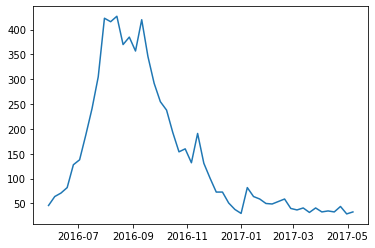

In [9]:
plt.plot(data)

In [10]:
N_H = 5.301e6
mu_H = 0.0142/365
mu_V = 1/14
gamma = 1/3

In [11]:
def deriv(t, y, beta_VH, beta_HV, m, b):
    S_H, I_H, S_V, I_V = y

    NHI = b * beta_VH * S_H * I_V / (m * N_H)
    NVI = b * beta_HV * S_V * I_H / N_H

    dSHdt = mu_H * N_H - NHI - mu_H * S_H
    dIHdt = NHI - gamma * I_H - mu_H * I_H

    dSVdt = mu_V * m * N_H - NVI - mu_V * S_V
    dIVdt = NVI - mu_V * I_V

    return dSHdt, dIHdt, dSVdt, dIVdt

In [12]:
def log_prior(theta):
    beta_VH, beta_HV, m, b, pV0 = theta

    if 0 < beta_VH < 0.66 and \
            0 < beta_HV < 0.66 and \
            15 < m < 1e4 and \
            0 < b < 30 and \
            0 < pV0 < 0.00075:
        return 0.0
    else:
        return -np.inf

In [13]:
def log_likelihood(theta, t, data):
    beta_VH, beta_HV, m, b, pV0 = theta
    sol = solve_ivp(deriv,
                    t_span=(0, len(t)),
                    t_eval=range(0, len(t)),
                    y0=(N_H - data[0],
                        data[0],
                        N_H * m * (1 - pV0),
                        N_H * m * pV0),
                    args=theta[:-1])

    ll = np.sum(- 1/2 * 1/t * np.sum(np.square(data[1:] - sol.y[1, :])))
    return ll

In [14]:
def log_probability(theta, t, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return log_likelihood(theta, t, data)

In [15]:
pos = np.array([0.3, 0.3, 200, 1/3, 0.001]) + 1e-4 * np.random.randn(32, 5)

In [16]:
backend = emcee.backends.HDFBackend("temp.hdf")
backend.reset(*(pos.shape))

In [17]:
sampler = emcee.EnsembleSampler(nwalkers=pos.shape[0],
                                ndim=pos.shape[1],
                                log_prob_fn=log_probability,
                                args=(np.arange(1, len(data)),
                                      data.to_numpy()))

sampler.run_mcmc(pos,
                 nsteps=25_000,
                 progress=True)

sampler.get_blobs(discard=1_000)

  0%|          | 0/25000 [00:00<?, ?it/s]/Users/csefalvayk/miniconda3/envs/lmfit/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [18:53<00:00, 22.06it/s]


In [18]:
beta_VH_hat, beta_HV_hat, m_hat, b_hat, pV0_hat = np.percentile(
    sampler.get_chain(flat=True),
    50,
    axis=0)

In [19]:
fit = solve_ivp(deriv,
                t_span=(0, len(data)),
                t_eval=np.arange(0, len(data)),
                y0=(N_H - data[0],
                    data[0],
                    N_H * m_hat * (1 - pV0_hat),
                    N_H * m_hat * pV0_hat),
                args=(beta_VH_hat, beta_HV_hat, m_hat, b_hat))

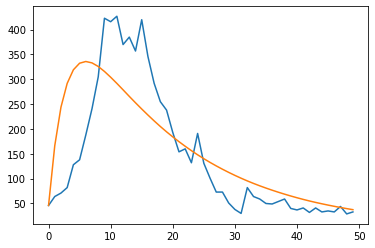

In [20]:
plt.plot(data.to_list())
plt.plot(fit.y.T[:, 1])

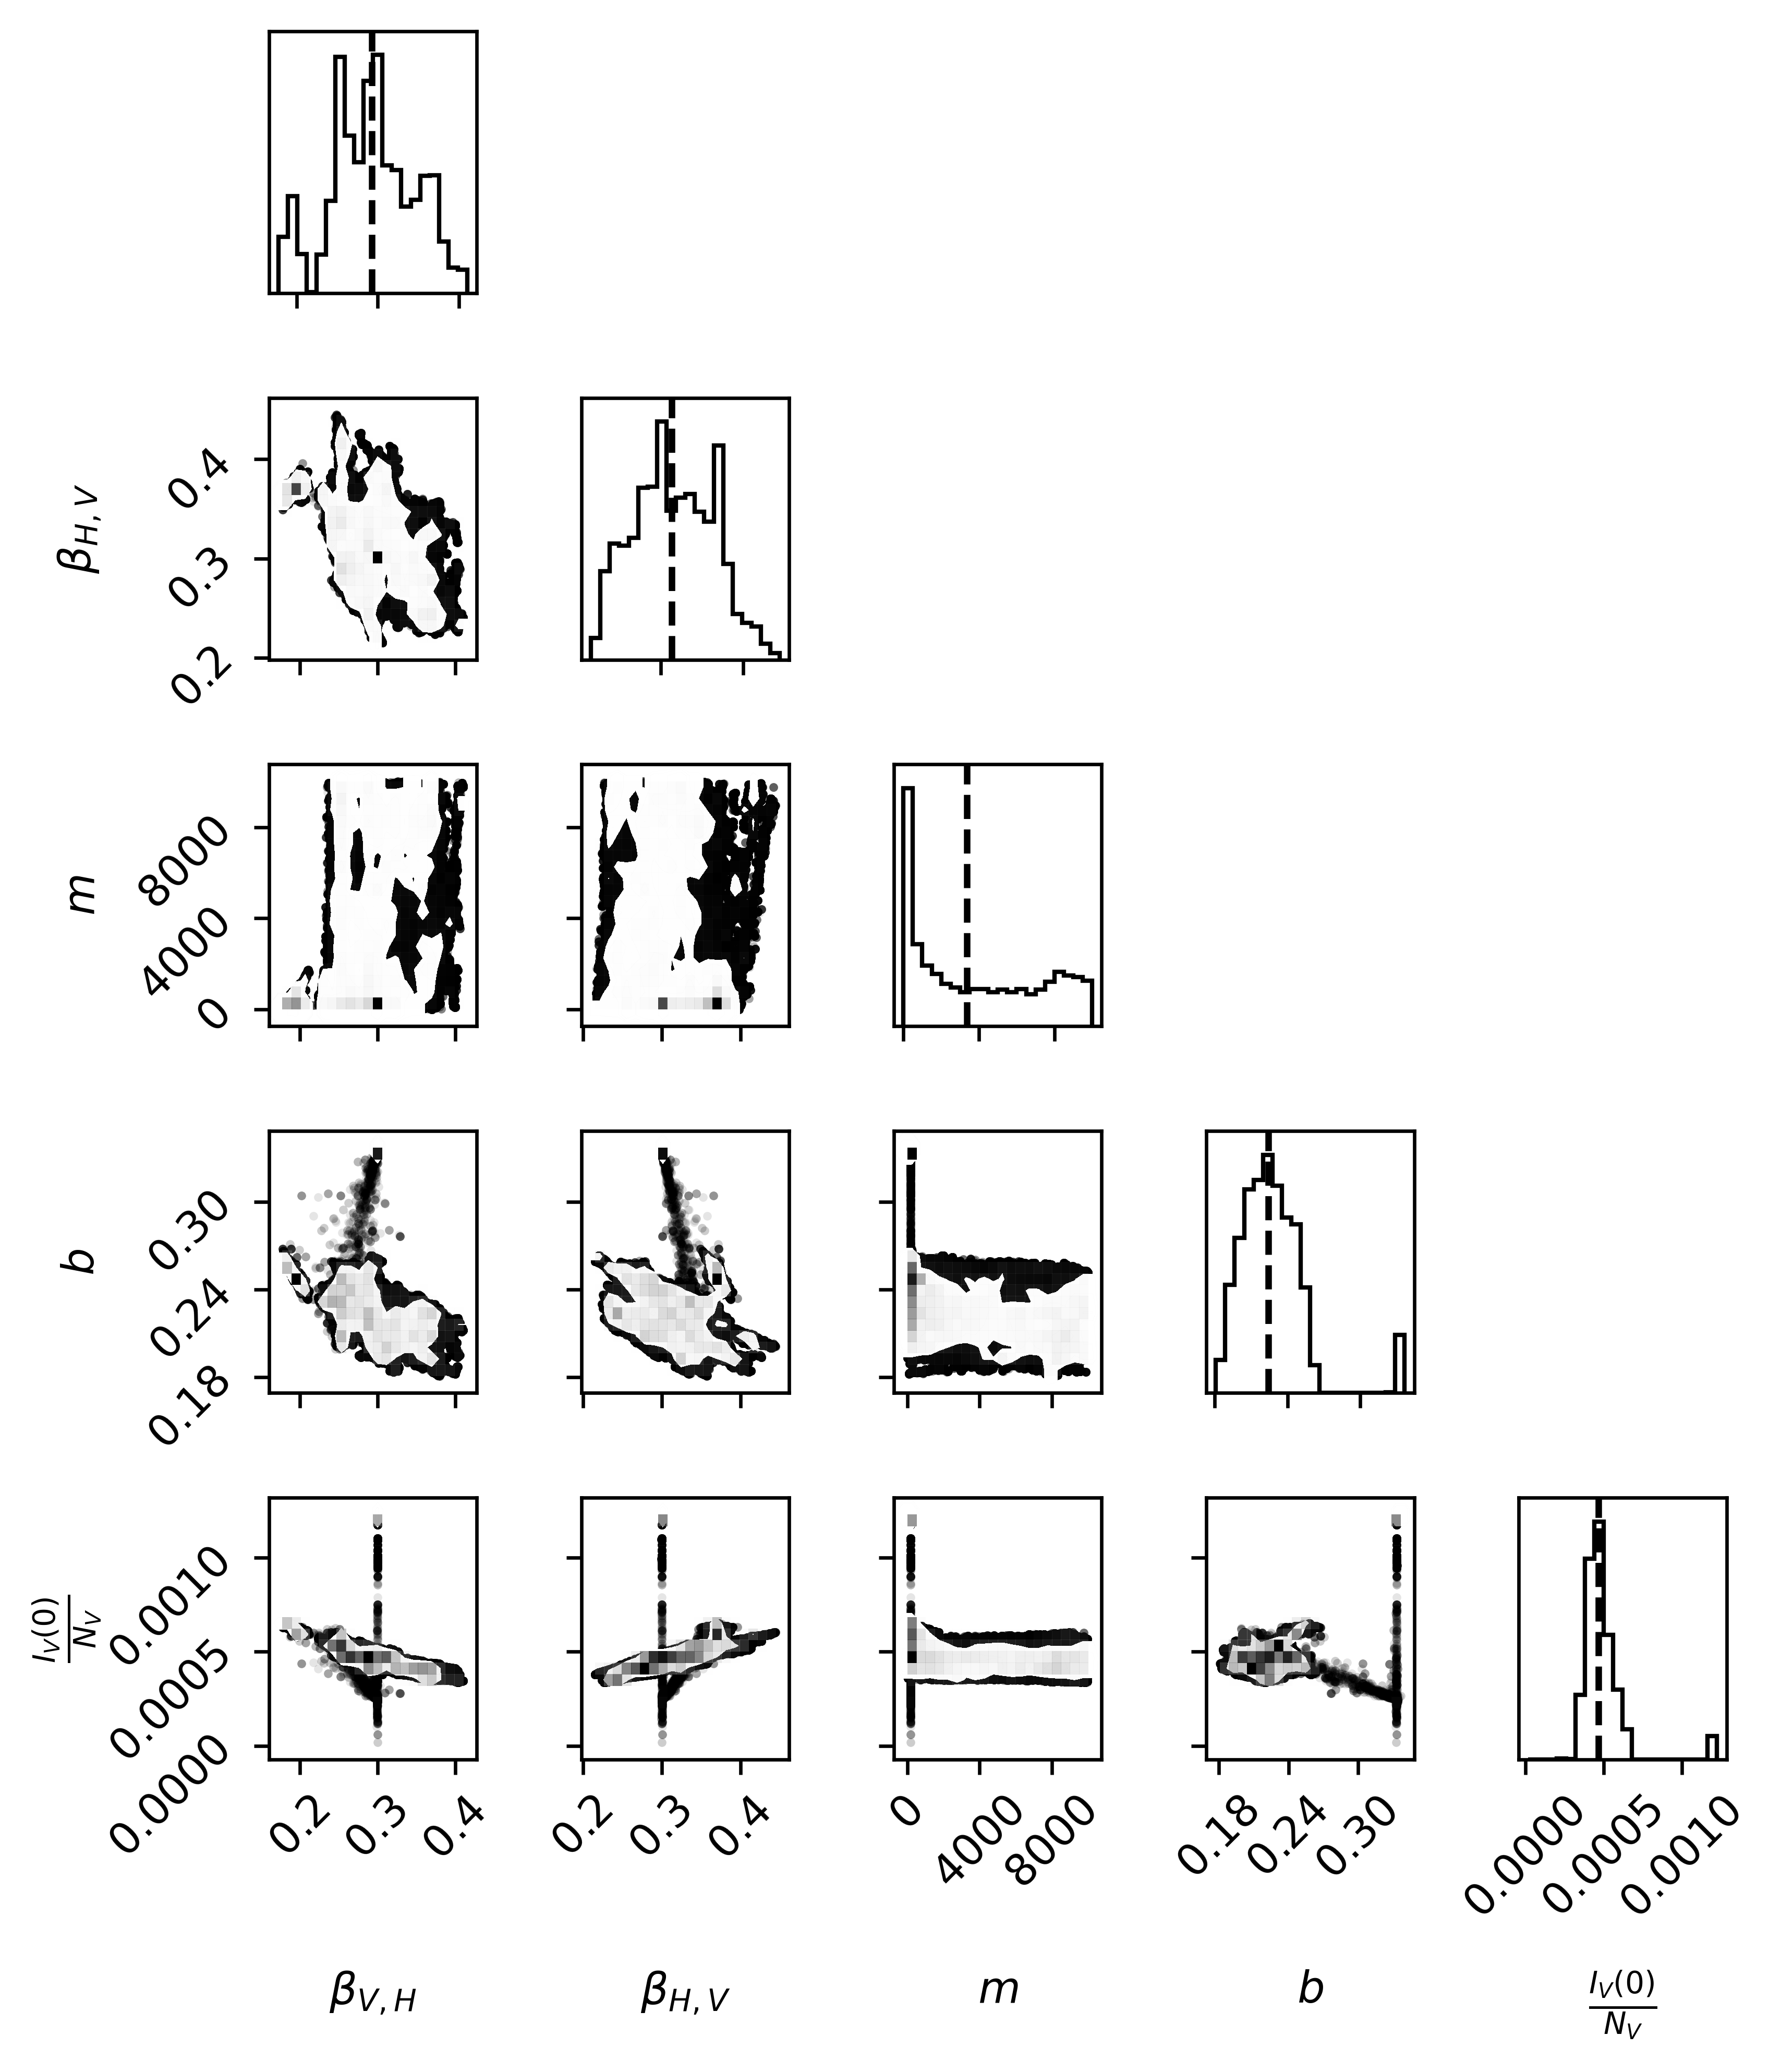

In [21]:
fig = plt.figure(figsize=(6, 7), dpi=600)
flat_samples = sampler.get_chain(flat=True)
corner.corner(flat_samples,
              labels=["$\\beta_{V,H}$", "$\\beta_{H,V}$", "$m$", "$b$", "$\\frac{I_V(0)}{N_V}$"],
              quantiles=[0.5],
              fig=fig,
              max_n_ticks=3,
              use_math_text=True,
              labelpad=0.5,
              contour_kwargs={"linewidths": 0.001})
plt.tight_layout()
plt.savefig("host_vector_pe.pdf")